In [1]:
import os
import ctypes
from symfit import variables, Parameter, ODEModel, D, Fit, parameters, Variable
import numpy as np
from uncertainties import ufloat as uf
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pathlib import Path as pt
from ipywidgets import widgets
from timescan import timescanplot
from time import time as start_time

%matplotlib inline

In [2]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# To display the figure defined by this dict, use the low-level plotly.io.show function
import plotly.io as pio

from widgetDefinitions import createWidgets
import string

alphabets = string.ascii_uppercase

def definingParameter(value):
    exec(value)
    return locals()

def getValfromAddress(address):
    return ctypes.cast(address, ctypes.py_object).value

def getValfromVariable(variable):
    address = id(variable)
    return getValfromAddress(address)

def float_slider(_value, _description, _min = -40, _max = -20, steps = 1e-3):
    return widgets.FloatLogSlider(
                value=_value,
                base=10,
                min=_min,
                max=_max,
                step=steps,
                description=_description
            )

In [3]:
style = {'description_width': 'initial', 'width':"100"}
layout=widgets.Layout(width='50%')

twidget = createWidgets(filetype="scan", multiselect=False, locationValue=r"D:\SurfDrive\THz_Measurements\CD+\timescan")
twidget.files.layout.height = "300px"

timeStartIndexWidget = widgets.BoundedIntText(value=1, description="timeStartIndex",min=0, style=style)
endtimeIndexWidget = widgets.BoundedIntText(value=-1, description="endtimeIndex", min=-1, style=style)

defaultInitialValueWidget = widgets.Checkbox(description="defaultInitialValue", value=False)
initialConditionValuesWidget = widgets.Text(description="initialConditionValues", style = style, value="", layout=layout)


tempWidget = widgets.BoundedFloatText(value=5, min=0, max=400, step=0.5, description="Temperature")

pbeforeWidget = widgets.FloatLogSlider(base=10, value=1e-8, min=-10, max=-4, description="pbefore")

paftereWidget = widgets.FloatLogSlider(base=10, value=1e-6, min=-10, max=-4, description="paftere")

parameterMinMaxStepForwardWidget = widgets.Text(description="parameterMinMaxStep", style = style, value="-40, -20, 0.001")
parameterMinMaxStepReverseWidget = widgets.Text(description="parameterMinMaxStep", style = style, value="-30, -10, 0.001")
moleculeWidget = widgets.Text(description="Molecule, tag", style = style, value="CD, Ne")
tdata = widgets.BoundedFloatText( value=5, min=1, max=20, step=0.25, description='Simulation:' )
logPlot = widgets.Checkbox(description="Log", value=True)
fitWidget = widgets.Checkbox(description="fit", value=False)

oldDataToggle = widgets.Checkbox(description="old Data", value=False)

In [4]:
rate_in_text = None
rate_output = widgets.Output()

def createModal(event=None):
    
    global rate_output, rate_in_text_widget
    
    with rate_output:
        print(locals())
        
        print(rate_in_text_widget.value)
        
        exec(rate_in_text_widget.value)
        
        print(f"{locals()['ode_modal']}")
        
        return locals()["ode_modal"]
    
rate_in_text_widget = widgets.Textarea(layout=widgets.Layout(width='70%', height="300px"), style = {'description_width': 'initial'})
rate_modal_button = widgets.Button(description="Create Modal", button_style="success", layout=widgets.Layout(width='20%'), style = {'description_width': 'initial'})
rate_modal_button_clear = widgets.Button(description="Clear", button_style="danger", layout=widgets.Layout(width='20%'), style = {'description_width': 'initial'})

rate_modal_button.on_click(createModal)
rate_modal_button_clear.on_click(lambda event: rate_output.clear_output())

In [5]:
massOfReactantsWidget = widgets.Text(description="massOfReactants", style = style, value=", ", layout=layout)
nameOfReactantsWidget = widgets.Text(description="nameOfReactants", style = style, value=", ", layout=layout)
nameOfParametersForwardWidget = widgets.Text(description="nameOfParametersForward", style = style,value=", ", layout=layout)
nameOfParametersReverseWidget = widgets.Text(description="nameOfParametersReverse", style = style,value=", ", layout=layout)

ROSAA_kinetics_widgets = {"massOfReactants":massOfReactantsWidget, "nameOfReactants":nameOfReactantsWidget, 
                          "timeStartIndex":timeStartIndexWidget, "endtimeIndex":endtimeIndexWidget, "initialConditionValues":initialConditionValuesWidget, "defaultInitialValue":defaultInitialValueWidget,
                          "fitODE":fitWidget, "parameterMinMaxStepForward":parameterMinMaxStepForwardWidget, "parameterMinMaxStepReverse": parameterMinMaxStepReverseWidget
                        }



In [6]:
numberDensityValue = None
def numberDensity(temp, pbefore, pafter):
    global numberDensityValue
    constant = 4.2e17 # 1/boltzman_constant*sqrt(T)
    C = uf(179.26, 3.79) # Calibration factor 
    T = uf(temp, 0.1) # Temperature
    p = pafter - pbefore
    numberDensityValue = (constant*C*p)/(T**0.5)
    print(f"{pbefore=}, {pafter=}")
    print(f"{numberDensityValue:.2e}")
    return numberDensityValue.nominal_value

numberDensityWidgetOutput = widgets.interactive_output(numberDensity, dict(temp=tempWidget, pbefore=pbeforeWidget, pafter=paftereWidget))


In [7]:
time, mass = None, None
errorDataValues = None
totalReactants = None
rateConstantSliderWidget = None

ode_modal = None
fullDataValues = None
label = None
expTime = None

rateConstantLength = 0

In [8]:
def ROSAA_kinetics(massOfReactants, nameOfReactants, timeStartIndex, endtimeIndex, 
                   initialConditionValues, defaultInitialValue, fitODE, parameterMinMaxStepForward, parameterMinMaxStepReverse,
                  filename = None):
    
    global ode_modal, fullDataValues, label, expTime, rate_in_text, rate_in_text_widget, rateConstantSliderWidget,\
            rateConstantLength, errorDataValues
    
    rate_in_text = []
    
    if massOfReactants == ", ": return 
    
    massLabel = massOfReactants.split(", ")
    totalReactants = len(massLabel)
    print(f"{totalReactants=}")
    
    nameOfParametersForward = ", ".join([f"k3{i}" for i in range(1, totalReactants)])
    nameOfParametersReverse = ", ".join([f"CID{i}" for i in range(1, totalReactants)])
    
    nameOfParametersForwardWidget.value = nameOfParametersForward
    nameOfParametersReverseWidget.value = nameOfParametersReverse
    
    # Getting timescan data
    expTime = time[timeStartIndex:] / 1000
    fullData = {}
    errorDataValues = {}
    
    for key in massLabel:
        fullData[key] = m[key]['y'][timeStartIndex:]
        errorDataValues[key] = m[key]['error_y']['array'][timeStartIndex:]
        
    fullDataValues = np.array(list(fullData.values()))
    errorDataValues = np.array(list(errorDataValues.values()))
    
    # Making variables
    t = Variable("t")
    rate_in_text.append(f't = Variable("t")')
    
    reactantVariable = []
    
    if nameOfReactants:
        reactantVariable = variables(nameOfReactants)
    else:
        print(f"{reactantVariable=} length not matching - {totalReactants}")
        return
    
    reactantVariable = reactantVariable[:totalReactants]
    rate_in_text.append(f'{nameOfReactants} = variables("{nameOfReactants}")')

    print(f"{reactantVariable=}")
    label = nameOfReactants.split(", ")[:totalReactants]
    
    fullDataDictionary = {key:value for key, value in zip(label, fullDataValues)}
    
    # Initial condition
    if defaultInitialValue:
        initialConditionValues = fullDataValues.T[0]
    else:
        if initialConditionValues:
            initialConditionValues = [float(_.strip()) for _ in initialConditionValues.split(",")]
        else:
            initialConditionValues = [fullDataValues[0].max()]
            for _ in range(totalReactants):
                initialConditionValues.append(0.0001)
        
        
    print(f"{initialConditionValues=}")
    initial_cond = {t:0}

    for i, variable in enumerate(reactantVariable):
        initial_cond[getValfromVariable(variable)] = initialConditionValues[i]

    print(f"{initial_cond=}")
    
    rate_in_text.append(f'initial_cond = {initial_cond}')
    
    # Rate Equation
    He = numberDensityValue.nominal_value
    
    rateConstantParametersForward = parameters(nameOfParametersForward)
    rateConstantParametersReverse = parameters(nameOfParametersReverse)
    
    rate_in_text.append(f'{nameOfParametersForward} = parameters("{nameOfParametersForward}")')
    rate_in_text.append(f'{nameOfParametersReverse} = parameters("{nameOfParametersReverse}")')
    
    if not fitODE:
        rateEquation = {"forward":[He**2 * getValfromVariable(i) for i in rateConstantParametersForward],
                        "reverse":[He * getValfromVariable(i) for i in rateConstantParametersReverse]}

        for forw, rever in zip(rateConstantParametersForward, rateConstantParametersReverse):
            getValfromVariable(forw).min = 1e-31
            getValfromVariable(forw).max = 1e-27

            getValfromVariable(rever).min = 1e-20
            getValfromVariable(rever).max = 1e-14
    
    else:
        rateEquation = {"forward":[getValfromVariable(i) for i in rateConstantParametersForward],
                        "reverse":[getValfromVariable(i) for i in rateConstantParametersReverse]}

        
    # Formation rate
    formationRate = {}

    for i, forward, reverse in zip(range(len(rateEquation["forward"])), rateEquation["forward"], rateEquation["reverse"]):
        formationRate[f"{label[i]}"] = -getValfromVariable(forward)*getValfromVariable(reactantVariable[i]) + getValfromVariable(reverse)*getValfromVariable(reactantVariable[i+1])

    formationRateList = list(formationRate.values())
    formationRate[f"{label[-1]}"] =  -formationRateList[-1]
    formationRateList = list(formationRate.values())
    
    # Rate Modal
    rate_in_text.append('rate_model = {}')
    
    rate_model = {D(getValfromVariable(reactantVariable[0]), t): getValfromVariable(formationRateList[0])}
    rate_in_text.append(f'rate_model[D({reactantVariable[0]}, t)] = {formationRateList[0]}')
    
    for i in range(1, totalReactants-1):
        rate_model[D(getValfromVariable(reactantVariable[i]), t)] =  getValfromVariable(formationRateList[i]) -getValfromVariable(formationRateList[i-1])
        rate_in_text.append(f'rate_model[D({reactantVariable[i]}, t)] = {formationRateList[i]} - {formationRateList[i-1]}')
        
    rate_model[D(getValfromVariable(reactantVariable[-1]), t)] = getValfromVariable(formationRateList[-1])
    rate_in_text.append(f'rate_model[D({reactantVariable[-1]}, t)] = {formationRateList[-1]}')
    
    for i, j in rate_model.items():
        print(f"\n{i}:{j}")
    
    ode_modal = ODEModel(rate_model, initial=initial_cond)
    print(f"{ode_modal=}")
    
    rate_in_text.append(f'ode_modal = ODEModel(rate_model, initial=initial_cond)')
    
    rate_in_text_widget.value = "\n".join(rate_in_text)
    #display(rate_in_text_widget, rate_modal_button, rate_modal_button_clear, rate_output)
    
    assert(ode_modal.dependent_vars[0] == list(ode_modal.initial.keys())[1])
    
    if fitODE:
        
        kwargs = {"t":expTime}
        counter = 0
        for _ in nameOfReactants.split(", "):
            kwargs[_] = fullDataValues[counter]
            counter += 1
            
        fit = Fit(ode_modal, **kwargs)
        fit_result = fit.execute()
        print(fit_result)
        
        return
    
    if not rateConstantLength == 2*totalReactants - 2:
        
        rateConstantSliderWidget = {"t":tdata}

        _minF, _maxF, _stepF = parameterMinMaxStepForward.split(", ")
        _minR, _maxR, _stepR = parameterMinMaxStepReverse.split(", ")

        for forwarLabel, reverseLabel in zip(nameOfParametersForward.split(", "), nameOfParametersReverse.split(", ")):
            _sliderWidgetForward = float_slider(1e-30, forwarLabel, _minF, _maxF, _stepF)
            _sliderWidgetReverse = float_slider(1e-15, reverseLabel, _minR, _maxR, _stepR)

            rateConstantSliderWidget[forwarLabel] = _sliderWidgetForward
            rateConstantSliderWidget[reverseLabel] = _sliderWidgetReverse
        
        rateConstantLength = len(list(rateConstantSliderWidget.values())) - 1
    
    rateConstantSliderWidget_K31 = list(rateConstantSliderWidget.values())[1::2]
    rateConstantSliderWidget_KCID = list(rateConstantSliderWidget.values())[2::2]
    
    rateConstantWidgetLayout = widgets.VBox([
        widgets.HBox([list(rateConstantSliderWidget.values())[0]]),
        widgets.HBox([*rateConstantSliderWidget_K31]),
        widgets.HBox([*rateConstantSliderWidget_KCID])
    ])
    
    final_output = widgets.interactive_output(func,  {"log":logPlot, **rateConstantSliderWidget})
    display(rateConstantWidgetLayout, logPlot, final_output)

ROSAA_kinetics_output = widgets.interactive_output(ROSAA_kinetics, {"filename": twidget.files, **ROSAA_kinetics_widgets})

In [9]:
def func(log=True, **kwargs):
    
    global ode_modal, rateConstantSliderWidget, errorDataValues
    
    # Simulation time
    simulationTime = kwargs["t"] = np.linspace(0, kwargs["t"], 1000)
    simulationData = ode_modal(**kwargs)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    twidget.fig = fig
    
    
    rateConstantSlider = list(rateConstantSliderWidget.values())[1:]
    rate_K3 = rateConstantSlider[::2]
    rate_KCID = rateConstantSlider[1::2]
    
    rateConstantValues = ["K$_{31}$"+ f"{rate_K3[0].value:.2e}"]
    
    for _ in range(1, int(len(rateConstantSlider)/2)):
        _temp = "K$_{CID}$"+ f"$_{_}$: {rate_KCID[_ - 1].value:.2e}; " + \
                "K$_3$"+ f"$_{_+1}$: {rate_K3[_].value:.2e}"
        rateConstantValues.append(_temp)
    
    rateConstantValues.append("K$_{CID}$"+ f"$_{int(len(rateConstantSlider)/2)}$: {rate_KCID[-1].value:.2e}")
    
    
    color = 0
    for sim, exp, lg in zip(simulationData, fullDataValues, label):
        ax.plot(simulationTime, sim, f"C{color}", label=f"{lg}$^+$: {rateConstantValues[color]}")
        ax.plot(expTime, exp, f".C{color}", ms=10)
        
        # errorDataValues[color][errorDataValues[color] == 0] = 1
        # _error = errorDataValues[color]
        # ax.errorbar(expTime, exp, fmt=f".C{color}", ms=10, yerr=_error)
        color += 1
    
    tag = moleculeWidget.value.split(",")[1].strip()
    ax.set(title=f"{twidget.files.value}: {tag} number density: {numberDensityValue.nominal_value:.2e}/cm3, Temp: {tempWidget.value}K")
    plt.ylabel('Counts')
    plt.xlabel('Time (s)')
    
    plt.grid()
    if log: plt.yscale('log')
    plt.legend()
    plt.show()
    plt.close('all')

In [10]:
display(twidget.update_files_button, twidget.location, twidget.files, oldDataToggle)
twidget.files.options = (f"{_}".replace(".txt", ".scan") for _ in pt(twidget.location.value).glob("*_timescan.txt"))

def init(location, filename, moleculeName, oldData=False):
    
    global time, mass, m, totalReactants
    
    if not filename: return print("No files selected")

    file = pt(location) / filename
    
    if oldData:
        file = pt(location) / f"{pt(filename).stem}.txt"
        time, *massesData = np.genfromtxt(file).T

        with open(file) as f:
            for i in f.readlines():
                if i.startswith("#Time"):
                    masses = [_.strip() for _ in i.split("\t")[1:-1]]
                    mass = [float(_) for _ in masses[:-1]]
                    
        m = {}
        for _, _data in enumerate(massesData):
            m[f"{masses[_]}u"] = {"x":list(time), "y":list(_data), "name":f"{masses[_]}u", 'mode': 'lines+markers'}
        
    else:
        time, mean, error, mass, t_res, t_b0  = timescanplot(file).get_data()
        m = timescanplot(file).get_fullmass()

    data = list(m.values())
    #iplot(data)
    fig = dict({
        "data": data,
        "layout": {"title": {"text": f"Timescan: {file.name}"}, "yaxis":{"type":"log"}}
    })
    pio.show(fig)
    
    massLabel = [f"{i}u" for i in mass]
    massOfReactantsWidget.value = ", ".join(massLabel)
    
    totalReactants = len(massLabel)
    
    twidget.savefilename.value = f"{pt(filename).stem}"
    
    molecule = moleculeName.split(",")[0].strip()
    tagName = moleculeName.split(",")[1].strip()
    moleculeTag = [molecule, f"{molecule}{tagName}"]
    
    for i in range(2, totalReactants):
        _temp = f"{molecule}{tagName}{i}"
        moleculeTag.append(_temp)
    
    nameOfReactantsWidget.value = ", ".join(moleculeTag)
    
    display(tempWidget, pbeforeWidget, paftereWidget, numberDensityWidgetOutput)
    print(f"{numberDensityWidgetOutput=}")
    
    
out = widgets.interactive_output(init, dict(location=twidget.location, filename=twidget.files,
                        oldData=oldDataToggle, moleculeName=moleculeWidget)
                         )

display(out)

ROSAA_kinetics_widget_display = widgets.VBox([
    widgets.HBox([moleculeWidget]),
    widgets.HBox([massOfReactantsWidget, nameOfReactantsWidget]),
    widgets.HBox([nameOfParametersForwardWidget, nameOfParametersReverseWidget]),
    widgets.HBox([timeStartIndexWidget, endtimeIndexWidget]),
    widgets.HBox([parameterMinMaxStepForwardWidget, parameterMinMaxStepReverseWidget]),
    widgets.HBox([defaultInitialValueWidget, initialConditionValuesWidget]),
])

display(ROSAA_kinetics_widget_display, ROSAA_kinetics_output)

display(twidget.savedpi, twidget.savefilename, twidget.savebutton, twidget.closebutton, twidget.output)

Button(button_style='success', description='update location', layout=Layout(width='20%'), style=ButtonStyle())

Text(value='D:\\SurfDrive\\THz_Measurements\\CD+\\timescan', description='scan location', layout=Layout(width=…

Select(description='scan files', layout=Layout(height='300px', width='70%'), options=('03_09_20-2.scan', '04_0…

Checkbox(value=False, description='old Data')

Output()

Output()

IntText(value=140, description='savedpi', step=2)

Text(value='', description='savefilename')

Button(button_style='success', description='Save', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

Output(outputs=({'output_type': 'stream', 'text': 'Getting scan from D:\\SurfDrive\\THz_Measurements\\CD+\\tim…

File exists: True
[1.79258280e+02 4.97481487e-05] [3.78937368e+00 1.54591150e-05]
Figure saved


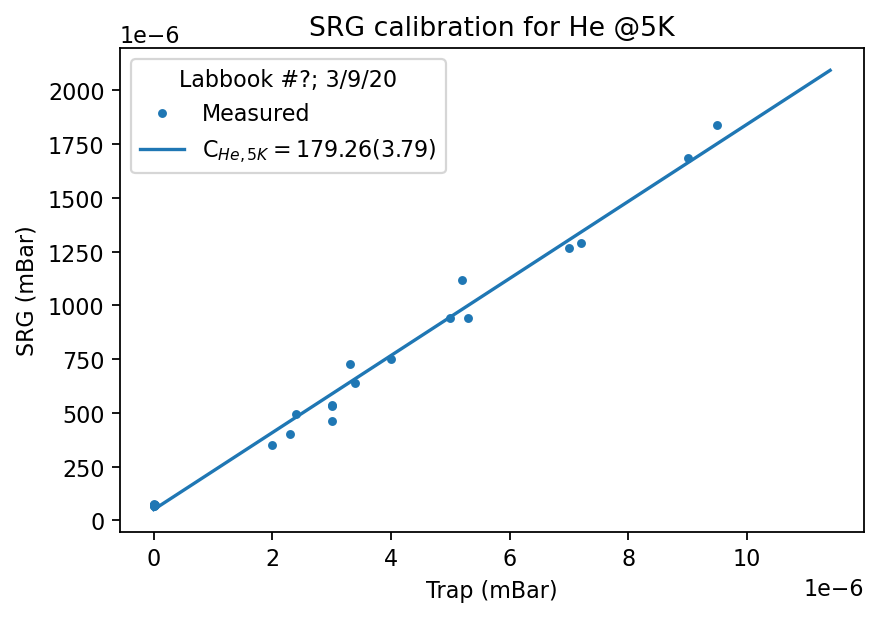

In [38]:
def srg_calib():
    srg_loc = pt(r"D:\SurfDrive\THz_Measurements\CD+\timescan\reports")
    srg_file = srg_loc / "srg_calibration.txt"
    print(f"File exists: {srg_file.exists()}")

    trap, srg = np.genfromtxt(srg_file).T

    # Define a model to fit to.
    def linearEq(x, slope, offset):
        return slope*x + offset

    popt, pcov = curve_fit(linearEq, trap, srg)
    perr = np.sqrt(np.diag(pcov))

    print(popt, perr)

    xfit = np.linspace(0, trap.max()+0.2*trap.max(), 50)
    yfit = linearEq(xfit, *popt)

    fig, ax = plt.subplots(dpi=160)
    ax.plot(trap, srg, ".C0")
    ax.plot(xfit, yfit, "-C0")
    plt.ticklabel_format(axis='both', style='sci', scilimits=(-6, -6))

    ax.set(title="SRG calibration for He @5K", xlabel="Trap (mBar)", ylabel="SRG (mBar)")
    ax.legend(["Measured", "C$_{He, 5K} = $"+f"{popt[0]:.2f}({perr[0]:.2f})"], title="Labbook #?; 3/9/20")

    fig.savefig(srg_loc/"srg_calibration.pdf")
    fig.savefig(srg_loc/"srg_calibration.png")

    print("Figure saved")

srg_calib()

In [22]:
if [1]:
    print("")